In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/Project_Stock/'

os.chdir(current_path)

Mounted at /content/drive


### **Requirements**

In [ ]:
# !pip install statsmodels==0.12.2

# import statsmodels
# statsmodels.__version__

### **ARIMA**

In [2]:
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime


def arima_test(target, use_rows=None):

  size = int(len(target) * 0.66)
  train, test = target[:size].values, target[size:]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 4))
      model_fit = model.fit()
      output = model_fit.forecast()
      # print(output)
      # break

      predictions.append(output[0])
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, tp=0.04, sl=None, leverage=1, show_detail=False, show_plot=False, return_pr=False, cumsum=False, 
                    close_ver=False, reverse_short=False):

  
  high, low, test = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)

  if close_ver:
    predictions = ohlcv['close'].shift(1).values[-len(test):]

  fee = 0.0006
  long_profits = []
  short_profits = []
  liquidations = []
  win_cnt = 0
  for i in range(len(test)):

    long_ep = predictions[i]
    if sl is not None:
      long_sl = long_ep * (1 / (sl + 1))

    # assert long_ep < long_exit, 'long_exit < long_ep !, %s, %s' % (long_exit, long_ep)
    
    short_ep = (predictions[i] + err_ranges[i]) * (1 + tp)
    # short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    if sl is not None:
      short_sl = short_ep * (1 / (1 - sl))

    # print((low[i]))

    #    long 우선   # <-- long & short 둘다 체결된 상황에서는 long 체결을 우선으로 한다.
    if low[i] < long_ep:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      liquidations.append(l_liquidation)

      if max(l_liquidation, 0) == 0:
        l_profit = 0
        # print('low[i], long_ep, l_liquidation :', low[i], long_ep, l_liquidation)
      else:

        if sl is not None:
          if low[i] < long_sl:
            profit = long_sl / long_ep - fee
          else:
            profit = test[i] / long_ep - fee

        else:
          profit = test[i] / long_ep - fee

        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      long_profits.append(l_profit)
      short_profits.append(1.0)

      if show_detail:
        print(test[i], predictions[i], long_ep)

    # if high[i] > short_ep > low[i]: # 지정 대기가 아니라, 해당 price 가 지나면, long 한다.

    #   if not reverse_short:
    #     liquidation = short_ep / high[i]  - fee
    #   else:
    #     liquidation = low[i] / short_ep  - fee
    #   l_liquidation = 1 + (liquidation - 1) * leverage

    #   if max(l_liquidation, 0) == 0:
    #     l_profit = 0
    #   else:

    #     if sl is not None:
    #       if high[i] > short_sl:

    #         if not reverse_short:
    #           profit = short_ep / short_sl - fee
    #         else:
    #           profit = short_sl / short_ep - fee

    #       else:
    #         if not reverse_short:
    #           profit = short_ep / test[i] - fee
    #         else:
    #           profit = test[i] / short_ep - fee

    #     else:

    #       if not reverse_short:
    #         profit = short_ep / test[i] - fee
    #       else:
    #         profit = test[i] / short_ep - fee

    #     l_profit = 1 + (profit - 1) * leverage
    #     l_profit = max(l_profit, 0)

    #     if profit >= 1:
    #       win_cnt += 1

    #   short_profits.append(l_profit)
    #   long_profits.append(1.0)

    #   if show_detail:
    #     print(test[i], predictions[i], short_ep)
    
    else:
      long_profits.append(1.0)
      short_profits.append(1.0)
      liquidations.append(1.0)


  long_win_ratio = sum(np.array(long_profits) > 1.0) / sum(np.array(long_profits) != 1.0)
  short_win_ratio = sum(np.array(short_profits) > 1.0) / sum(np.array(short_profits) != 1.0)
  long_frequency = sum(np.array(long_profits) != 1.0) / len(test)
  short_frequency = sum(np.array(short_profits) != 1.0) / len(test)
  if not cumsum:
    long_accum_profit = np.array(long_profits).cumprod()
    short_accum_profit = np.array(short_profits).cumprod()
  else:
    long_accum_profit = (np.array(long_profits) - 1.0).cumsum()
    short_accum_profit = (np.array(short_profits) - 1.0).cumsum()

  # print(win_ratio)

  if show_plot:

    plt.figure(figsize=(10, 5))
    plt.suptitle('tp=%.4f, lvrg=%d' % (tp, leverage))

    plt.subplot(151)
    plt.plot(liquidations)
    plt.title('liquidations')

    plt.subplot(152)
    plt.plot(long_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (long_win_ratio * 100, long_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(153)
    plt.plot(long_accum_profit)
    plt.title('Accum_profit : %.2f' % long_accum_profit[-1], color='black')

    plt.subplot(154)
    plt.plot(short_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (short_win_ratio * 100, short_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(155)
    plt.plot(short_accum_profit)
    plt.title('Accum_profit : %.2f' % short_accum_profit[-1], color='black')
    plt.show()

  return [long_win_ratio, short_win_ratio], [long_frequency, short_frequency], [long_accum_profit[-1], short_accum_profit[-1]], [long_profits, short_profits]


# get_back_result(tp=0.04, leverage=1, show_plot=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '30m'
date_path = './candlestick_concated/%s/2021-02-11/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-02-11 BTCUSDT.xlsx', '2021-02-11 ETHUSDT.xlsx', '2021-02-11 BCHUSDT.xlsx', '2021-02-11 XRPUSDT.xlsx', '2021-02-11 EOSUSDT.xlsx', '2021-02-11 LTCUSDT.xlsx', '2021-02-11 ETCUSDT.xlsx', '2021-02-11 LINKUSDT.xlsx', '2021-02-11 XLMUSDT.xlsx', '2021-02-11 ADAUSDT.xlsx', '2021-02-11 XMRUSDT.xlsx', '2021-02-11 SXPUSDT.xlsx', '2021-02-11 KAVAUSDT.xlsx', '2021-02-11 BANDUSDT.xlsx', '2021-02-11 DASHUSDT.xlsx', '2021-02-11 ZECUSDT.xlsx', '2021-02-11 XTZUSDT.xlsx', '2021-02-11 BNBUSDT.xlsx', '2021-02-11 ATOMUSDT.xlsx', '2021-02-11 ONTUSDT.xlsx', '2021-02-11 IOTAUSDT.xlsx', '2021-02-11 BATUSDT.xlsx', '2021-02-11 NEOUSDT.xlsx', '2021-02-11 QTUMUSDT.xlsx', '2021-02-11 WAVESUSDT.xlsx', '2021-02-11 MKRUSDT.xlsx', '2021-02-11 SNXUSDT.xlsx', '2021-02-11 DOTUSDT.xlsx', '2021-02-11 THETAUSDT.xlsx', '2021-02-11 ALGOUSDT.xlsx', '2021-02-11 KNCUSDT.xlsx', '2021-02-11 ZRXUSDT.xlsx', '2021-02-11 COMPUSDT.xlsx', '2021-02-11 OMGUSDT.xlsx']


### **Data Stacking**

In [ ]:
def resize_npy(x):

  temp_x = []

  for d_i, data in enumerate(x):
    # resized_data = cv2.resize(data, (row * 2, col * 2)) --> input image 홰손된다
    # resized_data = data.repeat(2, axis=0).repeat(2, axis=1)
    data = data.repeat(2, axis=0).repeat(2, axis=1)
    # resized_data = data.repeat(1, axis=0).repeat(1, axis=1)
    # cmapped = plt.cm.Set1(resized_data)[:, :, :3]  # Drop Alpha Channel
    
    if d_i == 0:
      plt.imshow(data)
      plt.show()
      # plt.imshow(resized_data)
      # plt.show()
    # print('resized_data.shape :', resized_data.shape)
    # break
    temp_x.append(data)

  return temp_x

start_stamp : 0
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 BTCUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

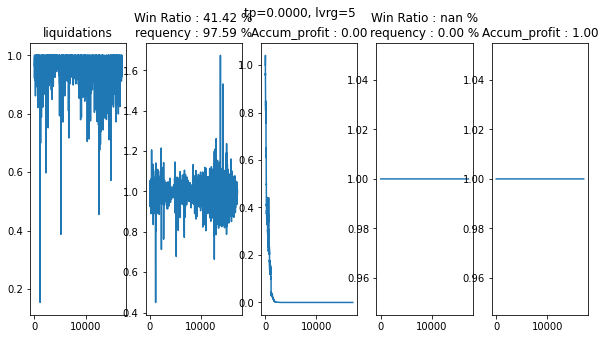

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16672, 45, 6)
input_x.shape : (16672, 45, 6)
input_x.dtype : float32
input_pr.shape : (16672, 1)
input_ud.shape : (16672, 1)
input_index.shape : (16672, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ETHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

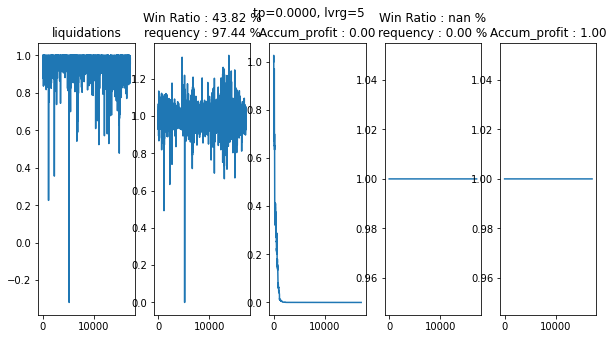

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16646, 45, 6)
input_x.shape : (16646, 45, 6)
input_x.dtype : float32
input_pr.shape : (16646, 1)
input_ud.shape : (16646, 1)
input_index.shape : (16646, 1)
total_x.shape : (33318, 45, 6)
total_pr.shape : (33318, 1)
total_ud.shape : (33318, 1)
prev_index.shape : (33318, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 BCHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

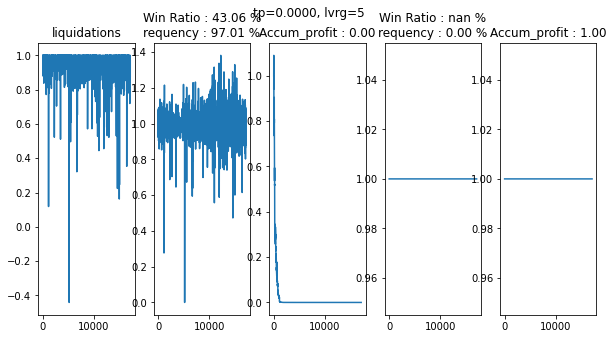

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16574, 45, 6)
input_x.shape : (16574, 45, 6)
input_x.dtype : float32
input_pr.shape : (16574, 1)
input_ud.shape : (16574, 1)
input_index.shape : (16574, 1)
total_x.shape : (49892, 45, 6)
total_pr.shape : (49892, 1)
total_ud.shape : (49892, 1)
prev_index.shape : (49892, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 XRPUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

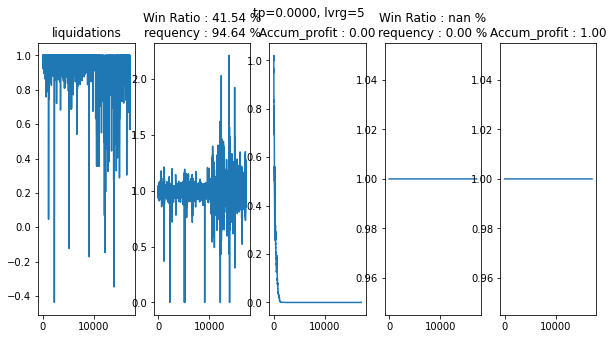

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16169, 45, 6)
input_x.shape : (16169, 45, 6)
input_x.dtype : float32
input_pr.shape : (16169, 1)
input_ud.shape : (16169, 1)
input_index.shape : (16169, 1)
total_x.shape : (66061, 45, 6)
total_pr.shape : (66061, 1)
total_ud.shape : (66061, 1)
prev_index.shape : (66061, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 EOSUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

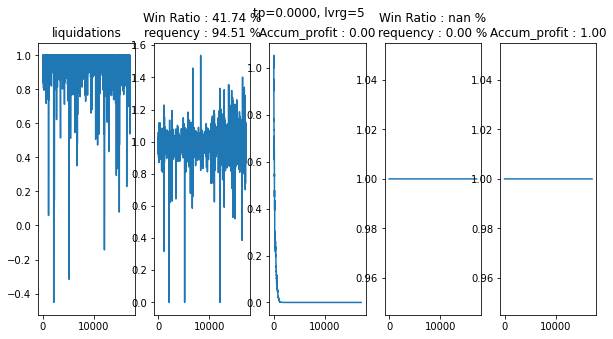

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16145, 45, 6)
input_x.shape : (16145, 45, 6)
input_x.dtype : float32
input_pr.shape : (16145, 1)
input_ud.shape : (16145, 1)
input_index.shape : (16145, 1)
total_x.shape : (82206, 45, 6)
total_pr.shape : (82206, 1)
total_ud.shape : (82206, 1)
prev_index.shape : (82206, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 LTCUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

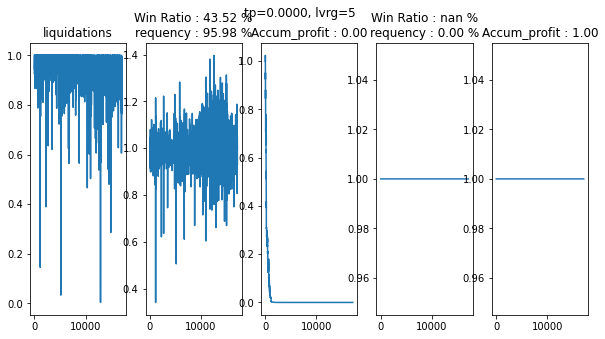

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16399, 45, 6)
input_x.shape : (16399, 45, 6)
input_x.dtype : float32
input_pr.shape : (16399, 1)
input_ud.shape : (16399, 1)
input_index.shape : (16399, 1)
total_x.shape : (98605, 45, 6)
total_pr.shape : (98605, 1)
total_ud.shape : (98605, 1)
prev_index.shape : (98605, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ETCUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

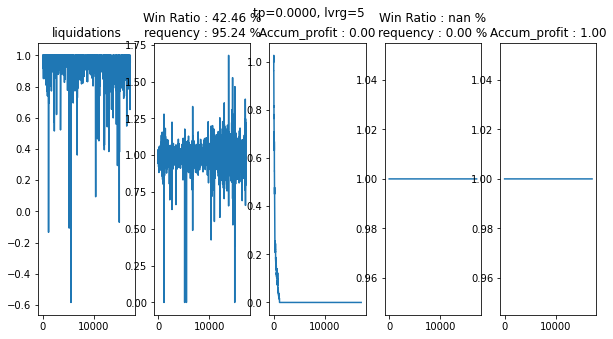

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16271, 45, 6)
input_x.shape : (16271, 45, 6)
input_x.dtype : float32
input_pr.shape : (16271, 1)
input_ud.shape : (16271, 1)
input_index.shape : (16271, 1)
total_x.shape : (114876, 45, 6)
total_pr.shape : (114876, 1)
total_ud.shape : (114876, 1)
prev_index.shape : (114876, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 LINKUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

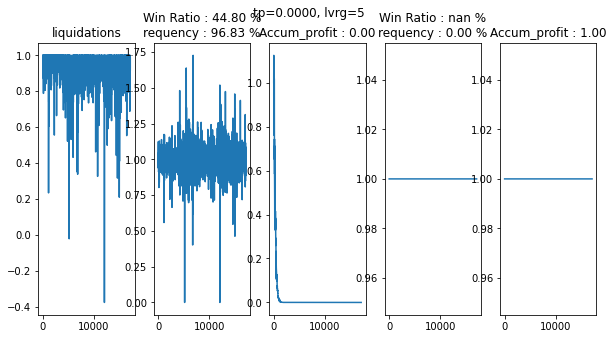

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16543, 45, 6)
input_x.shape : (16543, 45, 6)
input_x.dtype : float32
input_pr.shape : (16543, 1)
input_ud.shape : (16543, 1)
input_index.shape : (16543, 1)
total_x.shape : (131419, 45, 6)
total_pr.shape : (131419, 1)
total_ud.shape : (131419, 1)
prev_index.shape : (131419, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 XLMUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

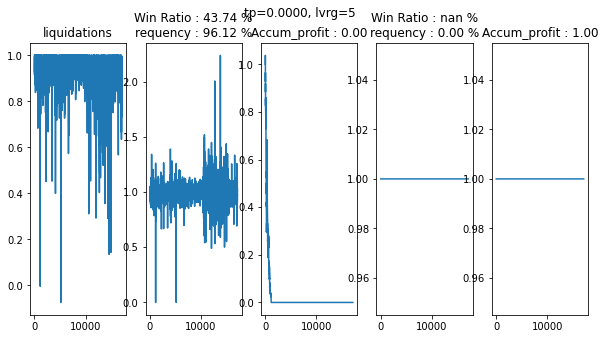

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16420, 45, 6)
input_x.shape : (16420, 45, 6)
input_x.dtype : float32
input_pr.shape : (16420, 1)
input_ud.shape : (16420, 1)
input_index.shape : (16420, 1)
total_x.shape : (147839, 45, 6)
total_pr.shape : (147839, 1)
total_ud.shape : (147839, 1)
prev_index.shape : (147839, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ADAUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

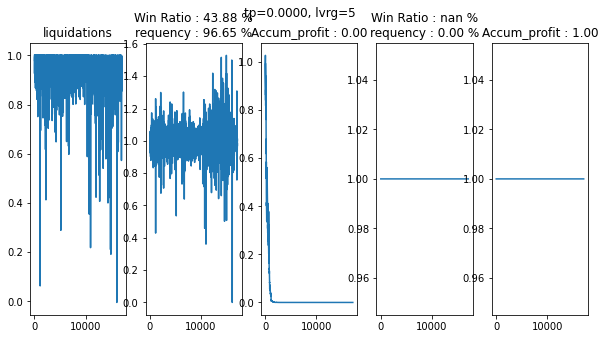

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16513, 45, 6)
input_x.shape : (16513, 45, 6)
input_x.dtype : float32
input_pr.shape : (16513, 1)
input_ud.shape : (16513, 1)
input_index.shape : (16513, 1)
total_x.shape : (164352, 45, 6)
total_pr.shape : (164352, 1)
total_ud.shape : (164352, 1)
prev_index.shape : (164352, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 XMRUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

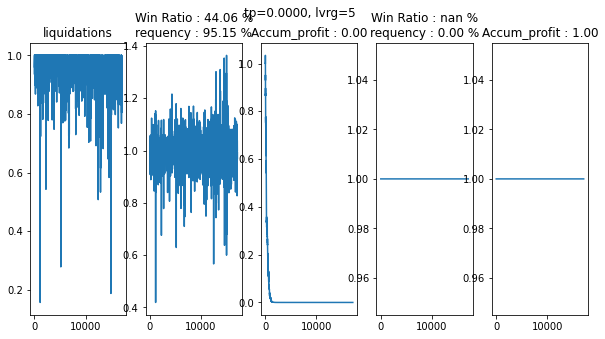

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16258, 45, 6)
input_x.shape : (16258, 45, 6)
input_x.dtype : float32
input_pr.shape : (16258, 1)
input_ud.shape : (16258, 1)
input_index.shape : (16258, 1)
total_x.shape : (180610, 45, 6)
total_pr.shape : (180610, 1)
total_ud.shape : (180610, 1)
prev_index.shape : (180610, 1)
len(ohlcv) : 12533
ohlcv.index[0] : 2020-07-21 18:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 SXPUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

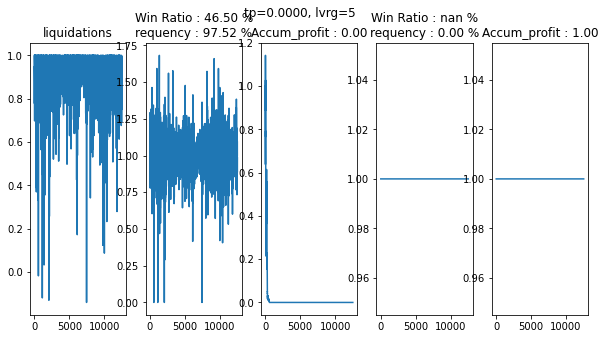

len(ohlc) : 12533
long_ep.shape : (12533, 1)
len(pr_list) : 12533
np.array(data_x).shape : (12180, 45, 6)
input_x.shape : (12180, 45, 6)
input_x.dtype : float32
input_pr.shape : (12180, 1)
input_ud.shape : (12180, 1)
input_index.shape : (12180, 1)
total_x.shape : (192790, 45, 6)
total_pr.shape : (192790, 1)
total_ud.shape : (192790, 1)
prev_index.shape : (192790, 1)
len(ohlcv) : 12201
ohlcv.index[0] : 2020-07-28 16:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 KAVAUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

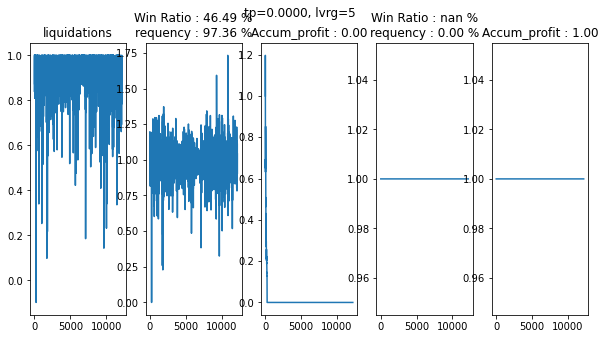

len(ohlc) : 12201
long_ep.shape : (12201, 1)
len(pr_list) : 12201
np.array(data_x).shape : (11837, 45, 6)
input_x.shape : (11837, 45, 6)
input_x.dtype : float32
input_pr.shape : (11837, 1)
input_ud.shape : (11837, 1)
input_index.shape : (11837, 1)
total_x.shape : (204627, 45, 6)
total_pr.shape : (204627, 1)
total_ud.shape : (204627, 1)
prev_index.shape : (204627, 1)
len(ohlcv) : 12153
ohlcv.index[0] : 2020-07-29 16:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 BANDUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

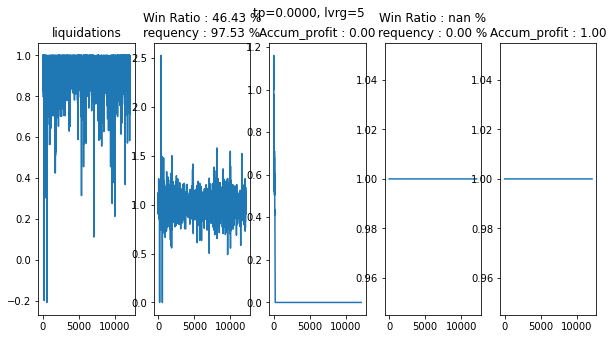

len(ohlc) : 12153
long_ep.shape : (12153, 1)
len(pr_list) : 12153
np.array(data_x).shape : (11811, 45, 6)
input_x.shape : (11811, 45, 6)
input_x.dtype : float32
input_pr.shape : (11811, 1)
input_ud.shape : (11811, 1)
input_index.shape : (11811, 1)
total_x.shape : (216438, 45, 6)
total_pr.shape : (216438, 1)
total_ud.shape : (216438, 1)
prev_index.shape : (216438, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 DASHUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

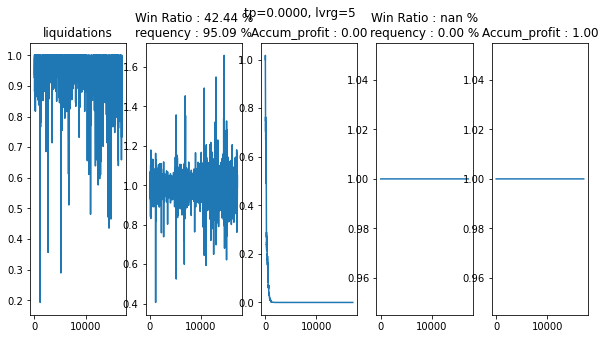

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16247, 45, 6)
input_x.shape : (16247, 45, 6)
input_x.dtype : float32
input_pr.shape : (16247, 1)
input_ud.shape : (16247, 1)
input_index.shape : (16247, 1)
total_x.shape : (232685, 45, 6)
total_pr.shape : (232685, 1)
total_ud.shape : (232685, 1)
prev_index.shape : (232685, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ZECUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

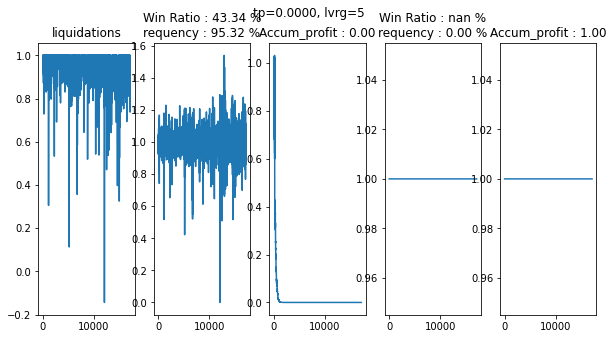

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16288, 45, 6)
input_x.shape : (16288, 45, 6)
input_x.dtype : float32
input_pr.shape : (16288, 1)
input_ud.shape : (16288, 1)
input_index.shape : (16288, 1)
total_x.shape : (248973, 45, 6)
total_pr.shape : (248973, 1)
total_ud.shape : (248973, 1)
prev_index.shape : (248973, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 XTZUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

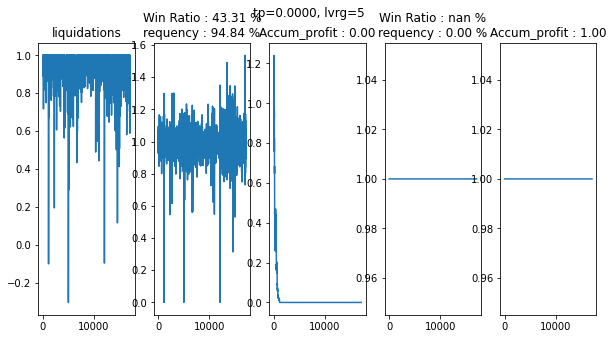

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16202, 45, 6)
input_x.shape : (16202, 45, 6)
input_x.dtype : float32
input_pr.shape : (16202, 1)
input_ud.shape : (16202, 1)
input_index.shape : (16202, 1)
total_x.shape : (265175, 45, 6)
total_pr.shape : (265175, 1)
total_ud.shape : (265175, 1)
prev_index.shape : (265175, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 BNBUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

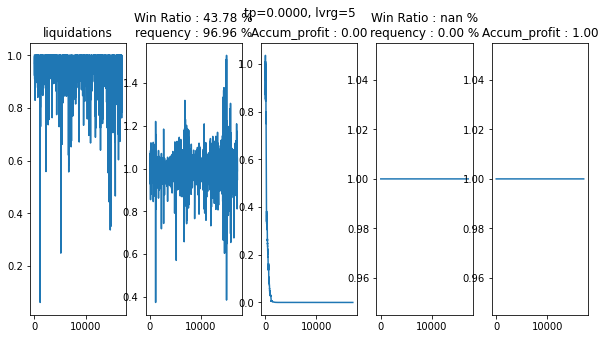

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16564, 45, 6)
input_x.shape : (16564, 45, 6)
input_x.dtype : float32
input_pr.shape : (16564, 1)
input_ud.shape : (16564, 1)
input_index.shape : (16564, 1)
total_x.shape : (281739, 45, 6)
total_pr.shape : (281739, 1)
total_ud.shape : (281739, 1)
prev_index.shape : (281739, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ATOMUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

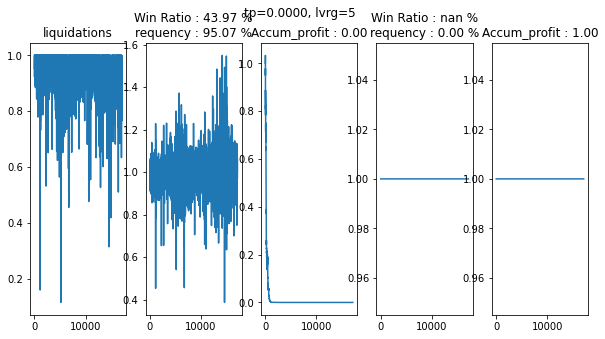

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16243, 45, 6)
input_x.shape : (16243, 45, 6)
input_x.dtype : float32
input_pr.shape : (16243, 1)
input_ud.shape : (16243, 1)
input_index.shape : (16243, 1)
total_x.shape : (297982, 45, 6)
total_pr.shape : (297982, 1)
total_ud.shape : (297982, 1)
prev_index.shape : (297982, 1)
len(ohlcv) : 17129
ohlcv.index[0] : 2020-04-17 00:29:59.999000
ohlcv.index[-1] : 2021-04-08 20:29:59.999000
-------------- 2021-04-08 ONTUSDT.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

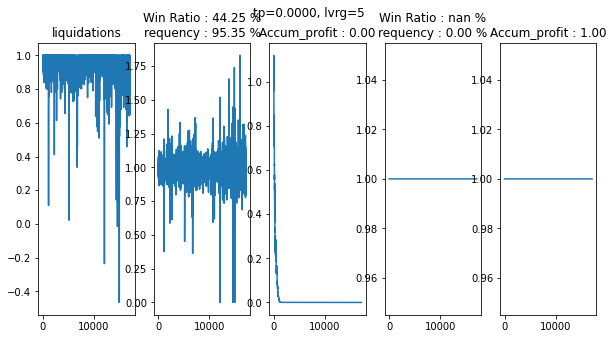

len(ohlc) : 17129
long_ep.shape : (17129, 1)
len(pr_list) : 17129
np.array(data_x).shape : (16288, 45, 6)
input_x.shape : (16288, 45, 6)
input_x.dtype : float32
input_pr.shape : (16288, 1)
input_ud.shape : (16288, 1)
input_index.shape : (16288, 1)
total_x.shape : (314270, 45, 6)
total_pr.shape : (314270, 1)
total_ud.shape : (314270, 1)
prev_index.shape : (314270, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import pickle
from sklearn.model_selection import train_test_split
from datetime import datetime

with open('./arima_result/prev_close_candi_profit_ls_only_long_result_%s.pickle' % interval, 'rb') as f:
  load_dict = pickle.load(f)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break


candis = list(load_dict.keys())
long_index = 0
leverage = 5
prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

for i in range(len(candis)):

  keys = [candis[i]]
  
  # if 'algo'.upper() not in candis[i]:
  #   continue
  if '2021-03-02 DOTUSDT.xlsx' in candis[i]:
    # print('')
    continue

  if '04-08' not in candis[i]:  # <-- 04-08 includes all timestamp range
    continue

  # if '02-11' not in candis[i]:  # <-- 04-08 includes all timestamp range
  #   continue  

  # if 'eth'.upper() not in candis[i]:
  #   continue

  # plt.figure(figsize=(35, 10))
  # plt.suptitle('%s %s' % (interval, keys))


  #         get tp parameter        #

  # plt.subplot(1,10,3)
  # for key in keys:  
  #   # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])
  #   argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
  #   peak_tp = profit_result_dict[key]['tp_list'][argmax]
  #   # plt.axvline(peak_tp, linestyle='--')
  #   # plt.title('acc profit, max at %.4f' % (peak_tp))  

  # plt.subplot(1,10,4)
  # plt.title('max acc profit by leverage')  
  # for key in keys:  
  #   # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
  #   argmax = np.argmax(profit_result_dict[key]['max_ap_list'][:, [long_index]])
  #   max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
  #   # plt.axvline(max_peak_tp, linestyle='--')
  #   # plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


  for key in keys:  
    # print(profit_result_dict[key]['leverage_ap_list'])

    # for tp in [max_peak_tp]:

      # if tp == peak_tp:
      #   plt.subplot(1,10,5)
      # else:
      #   plt.subplot(1,10,6)

      #     leverage analysis     #
      ohlcv = load_dict[key]['ohlcv']
      print('len(ohlcv) :', len(ohlcv))


      #       select timestamp range      #
      # time_index = ohlcv.index
      # total_stamp = list(map(lambda x: datetime.timestamp(x), time_index)) 

      # rm_index_amt = np.sum(np.array(total_stamp) < start_stamp)

      # ohlcv = ohlcv.iloc[rm_index_amt:]
      # print(ohlcv.head())

      # ohlcv = ohlcv.iloc[:-int(len(ohlcv) * 0.3)]  # exclude back_range
      # predictions = load_dict[key]['predictions']
      # err_ranges = load_dict[key]['err_ranges']
      print("ohlcv.index[0] :", ohlcv.index[0])
      print("ohlcv.index[-1] :", ohlcv.index[-1])

      predictions = ohlcv['close'].shift(1).values
      err_ranges = np.zeros_like(predictions)

      # leverage_list = profit_result_dict[key]['leverage_list']
      # temp_ap_list = list()
      # temp_pr_list = list()

      try:
        print('-------------- %s --------------' % key)
        result = get_back_result(ohlcv, predictions, err_ranges, tp=0, leverage=leverage, show_plot=True, reverse_short=False, show_detail=False)
        # temp_ap_list.append(result[2])
        # temp_pr_list.append(result[3])

        # if round(leverage) == 1:
        #   temp_pr_list = result[3]
        pr_list = result[3][long_index]

      except Exception as e:
        print(e)
        break    
  # break


      pd.set_option('display.max_rows', 500)
      pd.set_option('display.max_columns', 500)
      pd.set_option('display.width', 1000)

      #         clustering zone           #

      #       set data features : ohlc, v, ep
      time_index = ohlcv.index[-len(predictions):]
      ohlc = ohlcv.iloc[-len(predictions):, :4]
      vol = ohlcv.iloc[-len(predictions):, [4]]
      long_ep = np.array(predictions)
      long_ep = long_ep.reshape(-1, 1)

      ohlcv['u_wick'] = ohlcv['high'] / np.maximum(ohlcv['close'] , ohlcv['open'])
      ohlcv['d_wick'] = np.minimum(ohlcv['close'] , ohlcv['open']) / ohlcv['low']
      ohlcv['body'] = ohlcv['close'] / ohlcv['open']

      candle = ohlcv.iloc[-len(predictions):, -3:]


      print('len(ohlc) :', len(ohlc))
      print('long_ep.shape :', long_ep.shape)
      print('len(pr_list) :', len(pr_list))


      #       set params    #
      period = 45
      data_x, data_pr, data_updown = [], [], []
      data_index = []
      key_i = i

      for i in range(period, len(predictions)):

        #   pr_list != 1 인 데이터만 사용한다
        # if 1:
        if pr_list[i] != 1:
          
          #   prediction 을 제외한 이전 데이터를 사용해야한다
          temp_ohlc = ohlc.iloc[i - period : i].values
          temp_long_ep = long_ep[i - period : i]
          temp_vol = vol.iloc[i - period : i].values
          temp_candle = candle.iloc[i - period : i].values

          # print(temp_ohlc.shape)
          # print(temp_long_ep.shape)
          # print(temp_vol.shape)
          # print(temp_candle.shape)
          # break

          #   stacking  
          # temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol, temp_candle))
          temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol))
          # temp_data = np.hstack((temp_ohlc, temp_vol))

          # temp_data = np.hstack((temp_ohlc, temp_long_ep))
          # temp_data = temp_vol

          #   scaler 설정

          #   ohlc & ep -> max_abs
          # max_abs = MaxAbsScaler()
          # temp_data[:, :5] = max_abs.fit_transform(temp_data[:, :5])


          min_max = MinMaxScaler()
          temp_data[:, :5] = min_max.fit_transform(temp_data[:, :5])


          #   vol -> min_max
          min_max = MinMaxScaler()
          temp_data[:, [5]] = min_max.fit_transform(temp_data[:, [5]])


          #   candle -> max_abs    
          # max_abs = MaxAbsScaler()
          # temp_data[:, -3:] = max_abs.fit_transform(temp_data[:, -3:])

          # min_max = MinMaxScaler()
          # temp_data[:, -3:] = min_max.fit_transform(temp_data[:, -3:])

          if np.isnan(np.sum(temp_data)):
            continue

          data_x.append(temp_data)
          data_pr.append(pr_list[i])
          data_index.append(time_index[i])
          data_updown.append(ohlc['close'].iloc[i] / ohlc['open'].iloc[i])


      print('np.array(data_x).shape :', np.array(data_x).shape)
      # print(data_x[0])


      #       Reshape data for image deep - learning     #
      _, row, col = np.array(data_x).shape

      # input_x = np.array(data_x).reshape(-1, row, col, 1).astype(np.float32)
      input_x = np.array(data_x).reshape(-1, row, col).astype(np.float32)

      #     1c to 3c    #
      # input_x = input_x * np.ones(3, dtype=np.float32)[None, None, None, :]
      # input_x = np.array(resize_npy(input_x))


      input_pr = np.array(data_pr).reshape(-1, 1).astype(np.float32)
      input_ud = np.array(data_updown).reshape(-1, 1).astype(np.float32)
      input_index = np.array(data_index).reshape(-1, 1)
      print('input_x.shape :', input_x.shape)
      print('input_x.dtype :', input_x.dtype)
      print('input_pr.shape :', input_pr.shape)
      print('input_ud.shape :', input_ud.shape)
      print('input_index.shape :', input_index.shape)


      # x_train_, x_test, pr_train_, pr_test, ud_train_, ud_test = train_test_split(input_x, input_pr, input_ud, test_size=0.4, shuffle=False, random_state=random_state)
      # x_train, x_val, pr_train, pr_val, ud_train, ud_val = train_test_split(x_train_, pr_train_, ud_train_, test_size=0.25, shuffle=False, random_state=random_state)

      #     do stacking   #
      if prev_x is None:
        prev_x = input_x
        prev_pr = input_pr
        prev_ud = input_ud
        prev_index = input_index

        total_x = input_x
        total_pr = input_pr
        total_ud = input_ud
        total_index = input_index

      else:
        total_x = np.vstack((prev_x, input_x))
        total_pr = np.vstack((prev_pr, input_pr))
        total_ud = np.vstack((prev_ud, input_ud)) 
        total_index = np.vstack((prev_index, input_index)) 

        prev_x = total_x
        prev_pr = total_pr
        prev_ud = total_ud
        prev_index = total_index

        print('total_x.shape :', total_x.shape)
        print('total_pr.shape :', total_pr.shape)
        print('total_ud.shape :', total_ud.shape)
        print('prev_index.shape :', prev_index.shape)

      # if prev_train_x is None:
      #   prev_train_x = x_train
      #   prev_val_x = x_val
      #   prev_test_x = x_test
        
      #   prev_train_pr = pr_train
      #   prev_val_pr = pr_val
      #   prev_test_pr = pr_test

      #   prev_train_ud = ud_train
      #   prev_val_ud = ud_val
      #   prev_test_ud = ud_test

      # else:

      #   total_train_x = np.vstack((prev_train_x, x_train))
      #   total_val_x = np.vstack((prev_val_x, x_val))
      #   total_test_x = np.vstack((prev_test_x, x_test))
      #   total_train_pr = np.vstack((prev_train_pr, pr_train))
      #   total_val_pr = np.vstack((prev_val_pr, pr_val))
      #   total_test_pr = np.vstack((prev_test_pr, pr_test))
      #   total_train_ud = np.vstack((prev_train_ud, ud_train))
      #   total_val_ud = np.vstack((prev_val_ud, ud_val))
      #   total_test_ud = np.vstack((prev_test_ud, ud_test))
        
      #   prev_train_x = total_train_x
      #   prev_val_x = total_val_x
      #   prev_test_x = total_test_x
        
      #   prev_train_pr = total_train_pr
      #   prev_val_pr = total_val_pr
      #   prev_test_pr = total_test_pr

      #   prev_train_ud = total_train_ud
      #   prev_val_ud = total_val_ud
      #   prev_test_ud = total_test_ud
        
      #   print("total_train_x.shape :", total_train_x.shape)
      #   print("total_val_x.shape :", total_val_x.shape)
      #   print("total_test_x.shape :", total_test_x.shape)
      #   print("total_train_pr.shape :", total_train_pr.shape)
      #   print("total_val_pr.shape :", total_val_pr.shape)
      #   print("total_test_pr.shape :", total_test_pr.shape)
      #   print("total_train_ud.shape :", total_train_ud.shape)
      #   print("total_val_ud.shape :", total_val_ud.shape)
      #   print("total_test_ud.shape :", total_test_ud.shape)

  # break # --> use only one pair dataset

  #         chunks 로 나누지 않아도, generator 에서 batch_size 만큼만 load 할 것   #
  try:
    if len(total_x) > 300000:
      break
  except:
    pass

  
        

In [ ]:
period = 45

# _, row, col, _ = input_x.shape
_, row, col = input_x.shape

#       split new test      #

seed = 1
random_state = 201
np.random.seed(seed)
from sklearn.model_selection import train_test_split


#         get unique timestamp      #
print(np.unique(total_index, return_counts=True))
uniq_stamp = np.unique(total_index)

stamp_train_, stamp_test = train_test_split(uniq_stamp, test_size=0.2, shuffle=False, random_state=random_state)
stamp_train, stamp_val = train_test_split(stamp_train_, test_size=0.25, shuffle=True, random_state=random_state)

print("stamp_train.shape :", stamp_train.shape)
print("stamp_val.shape :", stamp_val.shape)
print("stamp_test.shape :", stamp_test.shape)
# break


#         split data by stamp     #
x_train, x_val, x_test = [], [], []
pr_train, pr_val, pr_test = [], [], []
index_train, index_val, index_test = [], [], []


from tqdm.notebook import tqdm

np.random.shuffle(total_index)

for i in tqdm(range(len(total_index))):

  if total_index[i] in stamp_train:
    x_train.append(total_x[i])
    pr_train.append(total_pr[i])
    index_train.append(total_index[i])

  elif total_index[i] in stamp_val:
    x_val.append(total_x[i])
    pr_val.append(total_pr[i])
    index_val.append(total_index[i])
  
  elif total_index[i] in stamp_test:
    x_test.append(total_x[i])
    pr_test.append(total_pr[i])
    index_test.append(total_index[i])


x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

pr_train = np.array(pr_train)
pr_val = np.array(pr_val)
pr_test = np.array(pr_test)

index_train = np.array(index_train)
index_val = np.array(index_val)
index_test = np.array(index_test)
  
print("x_train.shape :", x_train.shape) # x_train.shape : (3807, 90, 12, 3)
print("x_val.shape :", x_val.shape) # x_train.shape : (3807, 90, 12, 3)
print("x_test.shape :", x_test.shape) # x_train.shape : (3807, 90, 12, 3)

# del total_x

(array([Timestamp('2020-04-17 23:29:59.999000'),
       Timestamp('2020-04-17 23:59:59.999000'),
       Timestamp('2020-04-18 00:29:59.999000'), ...,
       Timestamp('2021-04-08 19:29:59.999000'),
       Timestamp('2021-04-08 19:59:59.999000'),
       Timestamp('2021-04-08 20:29:59.999000')], dtype=object), array([17, 17, 17, ..., 20, 20, 20]))
stamp_train.shape : (10248,)
stamp_val.shape : (3417,)
stamp_test.shape : (3417,)



x_train.shape : (185686, 45, 6)
x_val.shape : (62248, 45, 6)
x_test.shape : (66336, 45, 6)


In [ ]:
x_save_path = current_path + 'npy/' + '%s_rnn_close_updown_x_train_all_pair_timesplit.npy' % period
np.save(x_save_path, x_train)
np.save(x_save_path.replace('x_train', 'x_val'), x_val)
np.save(x_save_path.replace('x_train', 'x_test'), x_test)
# np.save(x_save_path.replace('x_train', 'new_input_x'), new_input_x)
print('x series saved !')

pr_save_path = current_path + 'npy/' + '%s_rnn_close_updown_pr_train_all_pair_timesplit.npy' % period
np.save(pr_save_path, pr_train)
np.save(pr_save_path.replace('pr_train', 'pr_val'), pr_val)
np.save(pr_save_path.replace('pr_train', 'pr_test'), pr_test)
# np.save(pr_save_path.replace('pr_train', 'new_input_pr'), new_input_pr)
print('pr series saved !')


x series saved !
pr series saved !


### Check shuffled index

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


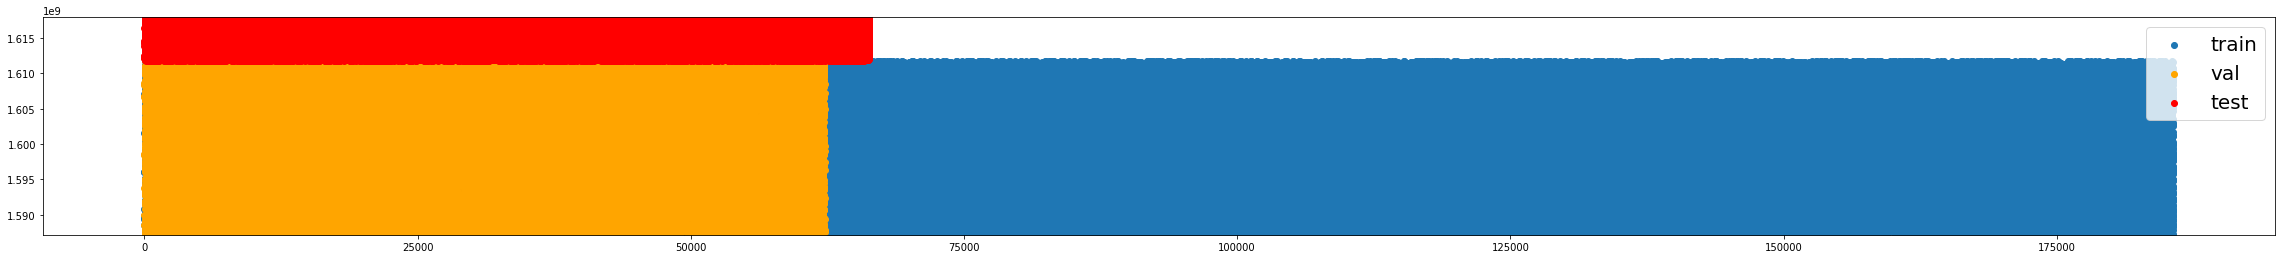

In [ ]:
# print(index_val)
from datetime import datetime

# print(index_test)
# print(index_train)
# print(index_val)
total_stamp = list(map(lambda x: datetime.timestamp(x[0]), input_index)) 
timestamp_train = list(map(lambda x: datetime.timestamp(x[0]), index_train)) 
timestamp_val = list(map(lambda x: datetime.timestamp(x[0]), index_val)) 
timestamp_test = list(map(lambda x: datetime.timestamp(x[0]), index_test)) 
# print(total_stamp)
# print(timestamp_train)
plt.figure(figsize=(40, 4))
plt.scatter(range(len(timestamp_train)), timestamp_train, label='train')
plt.scatter(range(len(timestamp_val)), timestamp_val, color='orange', label='val')
plt.scatter(range(len(timestamp_test)), timestamp_test, color='red', label='test')
plt.ylim(min(total_stamp), max(total_stamp))
plt.legend(fontsize=20)

# print(new_input_index)

### Load Data

In [5]:
period = 45

x_save_path = current_path + 'npy/' + '%s_rnn_close_updown_x_train_all_pair_timesplit.npy' % period
x_train = np.load(x_save_path)
x_val = np.load(x_save_path.replace('x_train', 'x_val'))
x_test = np.load(x_save_path.replace('x_train', 'x_test'))
print('x series loaded !')

pr_save_path = current_path + 'npy/' + '%s_rnn_close_updown_pr_train_all_pair_timesplit.npy' % period
pr_train = np.load(pr_save_path)
pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
print('y series loaded !')

_, row, col = x_train.shape



x series loaded !
y series loaded !


### **Model**

In [6]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

%tensorflow_version 1.x

import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display

%matplotlib inline

from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


gdrive_path = current_path

num_classes = 2

def FER_Model(input_shape=(row, col)):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    net = layers.LSTM(10, return_sequences=False)(visible)

    # net = layers.Dense(32)(visible)
    # net = layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.BatchNormalization()(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    # net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.BatchNormalization()(net)

    # net = layers.MaxPool2D(pool_size=2)(net)
    # net = layers.AveragePooling2D(padding='same')(net)

    shortcut_1 = net

    net = layers.Dense(128)(net)
    # net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(256)(net)
    # net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.BatchNormalization()(net)


    net = layers.Dropout(0.3)(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    # net = layers.Flatten()(net)
    net = layers.Dense(128)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs=visible, outputs=net)
    # summary layers
    print(model.summary())
    
    return model

TensorFlow 1.x selected.


Using TensorFlow backend.


In [7]:
print(keras.__version__)
print(tf.__version__)

2.3.1
1.15.2


### **Data Split**

In [8]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight
# import cv2


_, row, col, = x_train.shape

#         pr label   #
y_train = np.where(pr_train > 1, 1, 0)
y_test = np.where(pr_test > 1, 1, 0)
y_val = np.where(pr_val > 1, 1, 0)


seed = 1
random_state = 20
np.random.seed(seed)
# tf.random.set_seed(seed)

#         up label      #
# y_train = np.where(ud_train > 1, 1, 0)
# y_test = np.where(ud_test > 1, 1, 0)
# y_val = np.where(ud_val > 1, 1, 0)

# print('pr_train[:5] :', pr_train[:5])
# print('ud_train[:5] :', ud_train[:5])
print('y_train[:5] :', y_train[:5])
print('y_train.dtype :', y_train.dtype)

print('x_train.shape :', x_train.shape)
print('x_test.shape :', x_test.shape)
print('x_val.shape :', x_val.shape)
print('y_train.shape :', y_train.shape)
print('y_test.shape :', y_test.shape)
print('y_val.shape :', y_val.shape)

def class_ratio(in_list):

  return in_list / in_list[1]

print('np.unique(y_train, return_counts=True :', np.unique(y_train, return_counts=True), class_ratio(np.unique(y_train, return_counts=True)[1]))
print('np.unique(y_val, return_counts=True :', np.unique(y_val, return_counts=True), class_ratio(np.unique(y_val, return_counts=True)[1]))
print('np.unique(y_test, return_counts=True :', np.unique(y_test, return_counts=True), class_ratio(np.unique(y_test, return_counts=True)[1]))

label = y_train.reshape(-1, )
class_weights = class_weight.compute_class_weight('balanced', 
                                                    classes=np.unique(label),
                                                    y=label)
class_weights = dict(enumerate(class_weights))
print('class_weights :', class_weights)

# sample_weight = np.ones(shape=(len(y_train),))
# sample_weight[(y_train == 1).reshape(-1,)] = 1.5
# print('sample_weight[:20] :', sample_weight[:20])


print('np.isnan(np.sum(x_train)) :', np.isnan(np.sum(x_train)))
print('np.isnan(np.sum(x_val)) :', np.isnan(np.sum(x_val)))
print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))

print('np.isnan(np.sum(y_train)) :', np.isnan(np.sum(y_train)))
print('np.isnan(np.sum(y_val)) :', np.isnan(np.sum(y_val)))
print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

y_train_ohe = np_utils.to_categorical(y_train, num_classes)
y_val_ohe = np_utils.to_categorical(y_val, num_classes)
y_test_ohe = np_utils.to_categorical(y_test, num_classes)
print('y_train_ohe.shape :', y_train_ohe.shape)
print('y_val_ohe.shape :', y_val_ohe.shape)
print('y_test_ohe.shape :', y_test_ohe.shape)


y_train[:5] : [[0]
 [0]
 [0]
 [1]
 [1]]
y_train.dtype : int64
x_train.shape : (185686, 45, 6)
x_test.shape : (66336, 45, 6)
x_val.shape : (62248, 45, 6)
y_train.shape : (185686, 1)
y_test.shape : (66336, 1)
y_val.shape : (62248, 1)
np.unique(y_train, return_counts=True : (array([0, 1]), array([104757,  80929])) [1.29443092 1.        ]
np.unique(y_val, return_counts=True : (array([0, 1]), array([35161, 27087])) [1.29807657 1.        ]
np.unique(y_test, return_counts=True : (array([0, 1]), array([37331, 29005])) [1.28705396 1.        ]
class_weights : {0: 0.886270129919719, 1: 1.1472154604653462}
np.isnan(np.sum(x_train)) : False
np.isnan(np.sum(x_val)) : False
np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_train)) : False
np.isnan(np.sum(y_val)) : False
np.isnan(np.sum(y_test)) : False
y_train_ohe.shape : (185686, 2)
y_val_ohe.shape : (62248, 2)
y_test_ohe.shape : (66336, 2)


### **Training**

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'
# model_name = 'classifier_%s_close_updown_pr_theta_shuffle_without_back_03.h5' % period
# model_name = 'classifier_%s_close_updown_pr_theta_train_prevdata_005.h5' % period

# model_name = 'classifier_%s_close_updown_pr_theta_train_evendata_shuffle2_300k.h5' % period
# model_name = 'classifier_%s_lstm_close_updown_pr_neo_re_tf1_timesplit.h5' % period
# model = keras.models.load_model(ckpt_path + model_name)

batch_size = 8192
# _, row, col, = x_train.shape
# print("row, col :", row, col)

model = FER_Model(input_shape=(row, col))
opt = Adam(lr=0.00001, decay=0.000005)
# opt = Adam(lr=0.001, decay=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# model_name = 'classifier_%s_close_updown_pr_all_pair_shuffle_300k_timesplit.h5' % period
model_name = 'classifier_%s_lstm_close_updown_pr_all_pair_timesplit.h5' % period


checkpoint = ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = TensorBoard(log_dir=board_path,
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_loss', patience=40)
# callbacks_list = [checkpoint, checkpoint2, checkpoint3]
callbacks_list = [checkpoint, checkpoint2]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 1000                    

history = model.fit(x_train, y_train_ohe,
                    steps_per_epoch=int(len(x_train) / batch_size), 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    validation_data=(x_val, y_val_ohe),  
                    validation_steps=int(len(x_val) / batch_size),
                    shuffle=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 45, 6)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                680       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
____________________________________________

In [10]:
ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'
# model_name = 'classifier_45_close_updown_pr_theta_non_shuffle_ex_02008.h5'
# model_name = 'classifier_45_close_updown_pr_theta.h5'
# model_name = 'classifier_45_close_updown_pr_theta_train_evendata_shuffle2_300k.h5'
# model_name = 'classifier_45_lstm_close_updown_pr_neo_re_tf1_timesplit.h5'

model = keras.models.load_model(ckpt_path + model_name)

In [ ]:
org_x_test = x_test
org_y_test = y_test
org_pr_test = pr_test

In [ ]:
x_test = org_x_test
y_test = org_y_test
pr_test = org_pr_test

In [ ]:
concat_x = np.vstack((org_x_test, new_input_x))
concat_y = np.vstack((org_y_test, np.where(new_input_pr > 1, 1, 0)))
concat_pr = np.vstack((org_pr_test, new_input_pr))

In [ ]:
x_test = new_input_x
y_test = np.where(new_input_pr > 1, 1, 0)
pr_test = new_input_pr

66336/66336 [==============================] - 35s 524us/step
test_result.shape : (66336, 2)
y_test[:5] : [0 0 1 1 0]
y_score[:5] : [[0.43164992]
 [0.5376058 ]
 [0.49356213]
 [0.427348  ]
 [0.49336928]]
y_test.shape : (66336, 1)
y_score.shape : (66336, 1)
len(y_test) : 66336


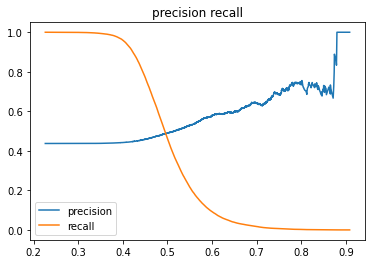

Streaming output truncated to the last 5000 lines.
precision : 0.6519823788546255
recall : 0.010205137045337011

np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_test)) : False

origin ac_pr : 0.0
win ratio improvement 0.44 --> 0.65
accum_pr increased ! : 0.000 --> 4446.261
thresh : 0.7242911
y_pred.shape : (66336,)
precision : 0.6534216335540839
recall : 0.010205137045337011

np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_test)) : False

origin ac_pr : 0.0
win ratio improvement 0.44 --> 0.65
accum_pr increased ! : 0.000 --> 4745.365
thresh : 0.72473
y_pred.shape : (66336,)
precision : 0.6548672566371682
recall : 0.010205137045337011

np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_test)) : False

origin ac_pr : 0.0
win ratio improvement 0.44 --> 0.65
accum_pr increased ! : 0.000 --> 4798.194
thresh : 0.72475845
y_pred.shape : (66336,)
precision : 0.656319290465632
recall : 0.010205137045337011

np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_test)) : False

origin ac_pr : 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in long_scalars


origin ac_pr : 0.0
win ratio improvement 0.44 --> nan
accum_pr increased ! : 0.000 --> 1.000
thresh : 0.9085146
acc_pr_bythr : [2.719717e-37, 2.9094328e-37, 2.8667724e-37, 2.7291978e-37, 2.6508267e-37, 2.6258078e-37, 2.7303025e-37, 2.7248484e-37, 2.695887e-37, 2.3331043e-37, 2.337818e-37, 2.3467841e-37, 2.3362186e-37, 1.998837e-37, 2.0527935e-37, 2.0094992e-37, 1.9388572e-37, 1.9743338e-37, 1.9732948e-37, 1.913526e-37, 1.976558e-37, 2.167377e-37, 2.231284e-37, 1.6463821e-37, 1.6791858e-37, 1.6558095e-37, 1.7196018e-37, 1.7181295e-37, 1.7233116e-37, 1.7219351e-37, 1.693474e-37, 1.6101595e-37, 1.6531385e-37, 1.6907481e-37, 1.6717251e-37, 1.6369205e-37, 1.6509258e-37, 1.6166197e-37, 1.6376159e-37, 1.6425256e-37, 1.7552403e-37, 1.7767981e-37, 1.7345943e-37, 1.7961423e-37, 1.6267642e-37, 1.6792466e-37, 1.6454201e-37, 1.6618316e-37, 1.6588534e-37, 1.6638428e-37, 1.6043393e-37, 1.5871411e-37, 1.5584543e-37, 1.5663246e-37, 1.5669724e-37, 1.5640677e-37, 1.5599194e-37, 1.59845e-37, 1.6432702e-37

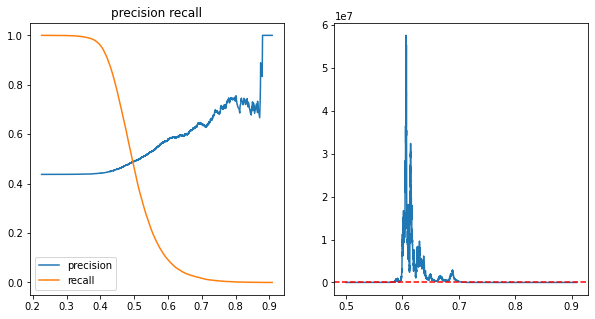

In [14]:
# x_test = new_input_x
# y_test = np.where(new_input_pr > 1, 1, 0)
# pr_test = new_input_pr

# x_test = org_x_test
# y_test = org_y_test
# pr_test = org_pr_test

# x_test = x_train
# y_test = y_train
# pr_test = pr_train

# x_test = x_val
# y_test = y_val
# pr_test = pr_val

# x_test = concat_x
# y_test = np.where(concat_pr > 1, 1, 0)
# pr_test = concat_pr

test_result = model.predict(x_test, verbose=1)
# test_result = model.predict(test_set)

print('test_result.shape :', test_result.shape)
# print('pr_val.shape :', pr_val.shape)

y_score = test_result[:, [1]]
print('y_test[:5] :', y_test.reshape(-1,)[:5])
# print('np.unique(y_test) :', np.unique(y_test, return_counts=True))
print('y_score[:5] :', y_score[:5])
# print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

print('y_test.shape :', y_test.shape)
print('y_score.shape :', y_score.shape)

print('len(y_test) :', len(y_test))

#     precision recall curve   #
precision, recall, threshold = precision_recall_curve(y_test, y_score)
precision, recall = precision[:-1], recall[:-1]

plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
plt.show()
# print(y_pred)


# threshold = [0.65]
# print('threshold :', threshold)
# break

acc_pr_bythr = []
new_thresh = []

for thresh in threshold:
  
  if thresh < 0.5:
      continue

  y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
  print('y_pred.shape :', y_pred.shape)
  # print('y_pred :', y_pred)

  #     compare precision     #

  print('precision :', precision_score(y_test, y_pred))
  print('recall :', recall_score(y_test, y_pred))
  print()

  print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
  print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

  # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
  # plt.show()  
  print()

  #     check win-ratio improvement     #
  cmat = confusion_matrix(y_test, y_pred)
  # print(cmat)
  # print(np.sum(cmat, axis=1))

  test_size = len(y_test)
  test_pr_list = pr_test
  print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

  org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
  ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
  print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

  # print('pr_test.shape :', pr_test.shape)

  # print(y_pred)
  # print(test_pr_list)
  pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
  pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
  pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)
  # print('pred_pr_list.shape :', pred_pr_list.shape)

  if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
    print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
    print('thresh :', thresh)
    
  # if len(threshold) == 1:
#   plt.figure(figsize=(10, 5))
#   plt.subplot(121)
#   plt.plot(np.cumprod(test_pr_list))
#   plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
# # plt.show()

#   plt.subplot(122)
#   plt.plot(np.cumprod(pred_pr_list))
#   plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
#   # plt.axvline(len(org_pr_test), linestyle='--', color='r')
#   plt.show()


  acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
  new_thresh.append(thresh)


print('acc_pr_bythr :', acc_pr_bythr)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
# plt.show()
plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.show()

In [ ]:
# print(pred_pr_list)
for pr in pred_pr_list:
  if pr != 1:
    print(pr)

In [ ]:
plt.figure(figsize=(50, 5))
plt.plot(np.cumprod(pred_pr_list)[len(org_pr_test):len(org_pr_test) + 10])
# plt.plot(np.cumprod(pred_pr_list)[len(org_pr_test) - 10:len(org_pr_test) + 10])
plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
# plt.axvline(len(org_pr_test), linestyle='--', color='r')
plt.show()

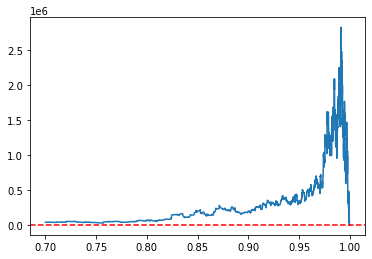

In [ ]:
# plt.show()
# plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.show()

#### **clustering output**

In [13]:
# x_train_for_k = test_result.flatten().reshape(-1, 1)
x_train_for_k = test_result
print(x_train_for_k[:10])
# x_train_for_k = test_result[:, [1]]
pr_train = pr_test

print('x_train_for_k.shape :', x_train_for_k.shape)
print('pr_train.shape :', pr_train.shape)

K = range(2, 10)
s_dist = []
sil = []
for k in K:
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(x_train_for_k)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(x_train_for_k, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()





#   with best_k, label 별 pr_list 확인
km = KMeans(n_clusters=best_k)
km = km.fit(x_train_for_k)

labels = km.labels_

print(km.score(x_train_for_k))
print(len(labels), len(pr_train))





#   label 별로 profit 을 저장, 승률을 확인한다
label_types = np.unique(labels, return_counts=False)

label_pr_dict = {}
#   init dict   #
for label in label_types:
  label_pr_dict[label] = []
print(label_pr_dict)
# break

for i, (label, pr) in enumerate(zip(labels, pr_train)):
  label_pr_dict[label].append(pr[0])

  
# for label in label_types:
print(label_pr_dict)





def win_ratio(list_x):

  win_cnt = np.sum(np.array(list_x) > 1)
  return win_cnt / len(list_x)


def acc_pr(list_x):

  return np.cumprod(np.array(list_x))[-1]


for key in label_pr_dict:
  
  print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))





#     predict test && test 의 라벨에 따른 win_ratio 확인
# test_labels = km.predict(x_test)
# # print(test_labels)

# label_pr_dict = {}
# #   init dict   #
# for label in label_types:
#   label_pr_dict[label] = []
# print(label_pr_dict)
# # break

# for i, (label, pr) in enumerate(zip(test_labels, pr_test)):
#   label_pr_dict[label].append(pr[0])

# for key in label_pr_dict:

#   print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))



[[0.56835014 0.43164992]
 [0.4623942  0.5376058 ]
 [0.50643784 0.49356213]
 [0.572652   0.427348  ]
 [0.5066307  0.49336928]
 [0.5065494  0.49345058]
 [0.49308822 0.5069118 ]
 [0.56036496 0.43963504]
 [0.6486162  0.35138384]
 [0.5338352  0.4661648 ]]
x_train_for_k.shape : (66336, 2)
pr_train.shape : (66336, 1)


KeyboardInterrupt: ignored